In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [2]:
from ase.build import bulk, fcc111

In [3]:
from ase.optimize import BFGS, FIRE
from ase.constraints import ExpCellFilter

In [4]:
from ase.visualize import view

# GPU: Tensorpotential calculator

In [5]:
from tensorpotential.calculator import TPCalculator

2024-11-14 11:41:23.271068: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-14 11:41:23.303022: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-14 11:41:23.303047: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-14 11:41:23.304026: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-14 11:41:23.309507: I tensorflow/core/platform/cpu_feature_guar

In [6]:
calc_tp = TPCalculator("../1-fit/seed/1/saved_model/")

2024-11-14 11:41:25.086244: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2024-11-14 11:41:25.086379: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 1817 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:b3:00.0, compute capability: 8.6


### Ir-FCC

In [7]:
Ir_bulk = bulk("Ir","fcc")
Ir_bulk

Atoms(symbols='Ir', pbc=True, cell=[[0.0, 1.92, 1.92], [1.92, 0.0, 1.92], [1.92, 1.92, 0.0]])

In [8]:
Ir_bulk.calc=calc_tp

In [9]:
Ir_bulk.get_potential_energy()

2024-11-14 11:41:26.365018: I external/local_xla/xla/service/service.cc:168] XLA service 0xf674e60 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-11-14 11:41:26.365045: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
2024-11-14 11:41:26.604522: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-11-14 11:41:27.158282: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
2024-11-14 11:41:29.736258: I external/local_xla/xla/stream_executor/gpu/asm_compiler.cc:326] ptxas warning : Registers are spilled to local memory in function 'fusion_7', 580 bytes spill stores, 580 bytes spill loads
ptxas warning : Registers are spilled to local memory in function 'fusion_259', 1772 bytes spill stores, 1708 bytes spill loads
ptxas warni

-9.758164191650565

In [10]:
Ir_bulk.get_stress()

array([ 3.00143611e-02,  3.00143611e-02,  3.00143611e-02,  1.17643465e-17,
        8.82325987e-18, -3.13715906e-17])

In [11]:
FIRE(ExpCellFilter(Ir_bulk)).run()

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:41:33       -9.758164*       0.4249
FIRE:    1 11:41:33       -9.760690*       0.0314


True

### Ir-FCC(111) surface

In [12]:
Ir_surface = fcc111("Ir", size=(2,2,10), periodic=True, vacuum=10)
Ir_surface

Atoms(symbols='Ir40', pbc=True, cell=[[5.430580079512685, 0.0, 0.0], [2.7152900397563426, 4.703020306143701, 0.0], [0.0, 0.0, 39.95322530319346]], tags=...)

In [13]:
# view(Ir_surface)

In [14]:
Ir_surface.calc=calc_tp

In [15]:
Ir_surface.get_potential_energy()

-376.1734471133577

In [16]:
BFGS(ExpCellFilter(Ir_surface)).run()

      Step     Time          Energy         fmax
BFGS:    0 11:41:40     -376.173447       31.8111
BFGS:    1 11:41:44      -10.433214     1892.0503
BFGS:    2 11:41:47     -376.411399       20.2066
BFGS:    3 11:41:47     -374.653764       65.2428
BFGS:    4 11:41:47     -376.537358        8.0638
BFGS:    5 11:41:47     -376.562730        3.2408
BFGS:    6 11:41:47     -376.572032        1.0874
BFGS:    7 11:41:47     -376.573692        1.2100
BFGS:    8 11:41:47     -376.576811        0.3460
BFGS:    9 11:41:47     -376.577052        0.0432


True

Some initial slowdown during the first two steps is due to JIT recompilation of the model, triggered by changes in the number of neighbors. However, thanks to padding, recompilations will only occur when a new padding size is required.

You can adjust these padding settings with the following options (at the cost of slightly increased overhead):

```python
calc_tp_with_more_padding = TPCalculator("fit/seed/1/saved_model/",
                                         pad_neighbors_fraction=0.2, # pad up to 20% extra neighbours
                                         pad_atoms_number=5 # pad up to 5 extra atoms
                                        )
```

# CPU: GRACE/FS calculator (with extrapolation grade)

In [17]:
from pyace.asecalc import PyGRACEFSCalculator

In [18]:
calc_fs=PyGRACEFSCalculator("../1-fit/seed/1/FS_model.yaml")

### Ir-FCC

In [19]:
Ir_bulk = bulk("Ir","fcc")
Ir_bulk

Atoms(symbols='Ir', pbc=True, cell=[[0.0, 1.92, 1.92], [1.92, 0.0, 1.92], [1.92, 1.92, 0.0]])

In [20]:
Ir_bulk.calc=calc_fs

In [21]:
Ir_bulk.get_potential_energy()

-9.758164191651225

In [22]:
Ir_bulk.get_stress()

array([3.00143609e-02, 3.00143609e-02, 3.00143609e-02, 1.89945178e-18,
       9.86489471e-18, 1.59921585e-17])

In [23]:
FIRE(ExpCellFilter(Ir_bulk)).run()

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 11:41:56       -9.758164*       0.4249
FIRE:    1 11:41:56       -9.760690*       0.0314


True

### Ir-FCC(111) surface

In [24]:
Ir_surface = fcc111("Ir", size=(2,2,10), periodic=True, vacuum=10)
Ir_surface

Atoms(symbols='Ir40', pbc=True, cell=[[5.430580079512685, 0.0, 0.0], [2.7152900397563426, 4.703020306143701, 0.0], [0.0, 0.0, 39.95322530319346]], tags=...)

In [25]:
# view(Ir_surface)

In [26]:
Ir_surface.calc=calc_fs

In [27]:
Ir_surface.get_potential_energy()

-376.17344711338245

In [28]:
BFGS(ExpCellFilter(Ir_surface)).run()

      Step     Time          Energy         fmax
BFGS:    0 11:41:58     -376.173447       31.8111
BFGS:    1 11:41:58      -10.433214     1892.0503
BFGS:    2 11:41:58     -376.411399       20.2066
BFGS:    3 11:41:58     -374.653764       65.2428
BFGS:    4 11:41:58     -376.537358        8.0638
BFGS:    5 11:41:58     -376.562730        3.2408
BFGS:    6 11:41:58     -376.572032        1.0874
BFGS:    7 11:41:58     -376.573692        1.2100
BFGS:    8 11:41:58     -376.576811        0.3462
BFGS:    9 11:41:59     -376.577052        0.0433


True

## Extrapolation grade gamma

one need to set active set (ASI), computed previously with `pace_activeset` utility

In [29]:
calc_fs.set_active_set("../1-fit/seed/1/FS_model.asi")

### Ir-FCC

In [30]:
Ir_bulk.calc=calc_fs

In [31]:
Ir_bulk.get_potential_energy()

-9.76068986767721

In [32]:
Ir_bulk.calc.results['gamma']

array([0.57877347])

bulk atoms are in interpolation regime ($\gamma<=1$)

Let us consider E-lattice constant curve with extrapolation grade

In [33]:
a_list=np.linspace(1.0, 8, num=75)

energy_list=[]
gamma_list=[]

for a in a_list:
    at = bulk("Ir","fcc",a=a)
    at.calc=calc_fs
    
    e=at.get_potential_energy()
    gamma=at.calc.results['gamma'].max()
    
    energy_list.append(e)
    gamma_list.append(gamma)

In [34]:
gamma_list=np.array(gamma_list)

energy_list=np.array(energy_list)

mask = gamma_list<=1 # interpolation region

Text(0, 0.5, 'Gamma')

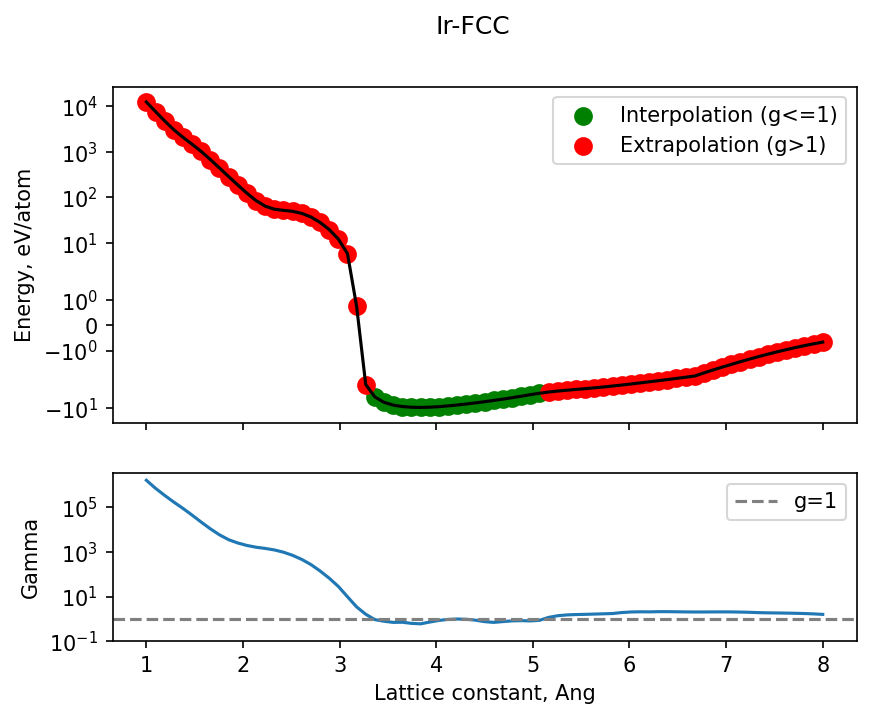

In [35]:
fig, axs= plt.subplots(nrows=2, ncols=1, sharex=True, height_ratios = [2,1], dpi=150)

fig.suptitle("Ir-FCC")
#### energy ###
axs[0].plot(a_list, energy_list, color='black')
axs[0].scatter(a_list[mask], energy_list[mask], lw=3, color="green", label='Interpolation (g<=1)')
axs[0].scatter(a_list[~mask], energy_list[~mask], lw=3, color="red", label='Extrapolation (g>1)')

axs[0].legend()
axs[0].set_yscale('symlog')
axs[0].set_ylabel("Energy, eV/atom")

#### gamma ###
axs[1].plot(a_list, gamma_list)
axs[1].set_yscale('log');
axs[1].set_xlabel("Lattice constant, Ang")


axs[1].axhline(1.0, ls='--', color='gray', label='g=1')
axs[1].legend()
axs[1].set_ylim(0.1, None)
axs[1].set_ylabel("Gamma")

### Ir-FCC(111) surface

In [36]:
Ir_surface.calc=calc_fs

In [37]:
Ir_surface.get_potential_energy()

-376.5770521419114

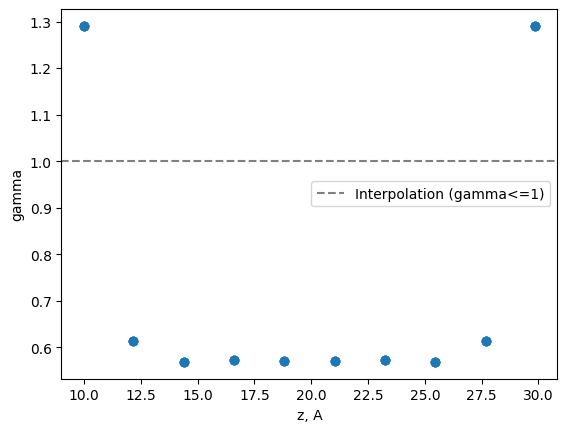

In [38]:
plt.scatter(Ir_surface.positions[:,2], calc_fs.results['gamma'])
plt.xlabel("z, A")
plt.ylabel("gamma")
plt.axhline(1.0, ls="--", color='gray', label='Interpolation (gamma<=1)')
plt.legend()

Since our training dataset for this particular tutorial contains only bulk-like structures, surface atoms are in extrapolation regime ($\gamma>1$), bulk atoms are in interpolation regime ($\gamma<=1$)

In [39]:
Ir_surface

Atoms(symbols='Ir40', pbc=True, cell=[[5.383868644286448, -3.053618330288136e-07, 1.1100055624351724e-07], [2.6919340576921247, 4.662595090478068, 9.302107949295722e-06], [8.16640244220394e-07, 7.855203154354398e-05, 39.835806675452005]], tags=..., calculator=PyGRACEFSCalculator(...))

Save Ir_surface for LAMMPS

In [40]:
from ase.io import write

In [41]:
write("../3-lammps/Ir_fcc_111_surf.lammps-data", Ir_surface, format='lammps-data', specorder=['Ir'])